# Real-world Data Wrangling

In this project, you will apply the skills you acquired in the course to gather and wrangle real-world data with two datasets of your choice.

You will retrieve and extract the data, assess the data programmatically and visually, accross elements of data quality and structure, and implement a cleaning strategy for the data. You will then store the updated data into your selected database/data store, combine the data, and answer a research question with the datasets.

Throughout the process, you are expected to:

1. Explain your decisions towards methods used for gathering, assessing, cleaning, storing, and answering the research question
2. Write code comments so your code is more readable

## 1. Gather data

In this section, you will extract data using two different data gathering methods and combine the data. Use at least two different types of data-gathering methods.

### **1.1.** Problem Statement
In 2-4 sentences, explain the kind of problem you want to look at and the datasets you will be wrangling for this project.

I will be examining usage of Japanese in the author-supplied descriptions of popular free Internet fiction ("webnovels") to see how the language used differs from how Japanese is used elsewhere. For my baseline for Japanese usage, I will be using a 2017 dataset containing the 15,000 most common Japanese lemmas (that is, regarding different forms of the same term as the same) in the Internet Corpus, posted on Kaggle by user Rachael Tatman. Webnovel summaries will be taken from the top stories posted on Shousetsuka ni Narou, the most popular Japanese webnovel site.

For this notebook, I used the same Conda environment I'd been using for the rest of this course. Its current dependencies, taken from `conda env export --from-history`, are:
  - spacy
  - jupyter
  - matplotlib
  - nltk
  - numpy
  - openpyxl
  - pandas
  - pip-system-certs
  - python
  - scikit-learn
  - seaborn
  - sqlalchemy

### **1.2.** Gather at least two datasets using two different data gathering methods

List of data gathering methods:

- Download data manually
- Programmatically downloading files
- Gather data by accessing APIs
- Gather and extract data from HTML files using BeautifulSoup
- Extract data from a SQL database

Each dataset must have at least two variables, and have greater than 500 data samples within each dataset.

For each dataset, briefly describe why you picked the dataset and the gathering method (2-3 full sentences), including the names and significance of the variables in the dataset. Show your work (e.g., if using an API to download the data, please include a snippet of your code). 

Load the dataset programmtically into this notebook.

#### **Dataset 1**

Type: CSV file

Method: File downloaded from [Kaggle page](https://www.kaggle.com/datasets/rtatman/japanese-lemma-frequency).

Dataset variables:

*   `rank`: Lemma's position in the ranking of the 15,000 most common.
*   `frequency`: Number of times the lemma occurs in the corpus, relative to a baseline. This is described as "number of times it occurs in the corpus", but is not an integer; values range from 41309.5 to 2.24, with a median of 6.42 and some recorded values differing by as little as 0.01.
*   `lemma`: The lemma itself.

In [1]:
import pandas as pd
import numpy as np

#FILL IN 1st data gathering and loading method
rtatman_ranking = pd.read_csv("japanese_lemmas.csv")
rtatman_ranking.head()

,rank,frequency,lemma
0,1,41309.50,の
1,2,23509.54,に
2,3,22216.80,は
3,4,20431.93,て
4,5,20326.59,を


In [2]:
rtatman_ranking.describe()

,rank,frequency
count,15000.000000,15000.000000
mean,7500.500000,52.257601
std,4330.271354,641.211909
min,1.000000,2.240000
25%,3750.750000,3.510000
50%,7500.500000,6.420000
75%,11250.250000,16.782500
max,15000.000000,41309.500000


#### Dataset 2

Type: API

Method: The data was downloaded via the official "Narou Novel API" for popular website Shousetsuka ni Narou, documented [here](https://dev.syosetu.com/man/api/) and translated with built-in web browser tools.

Dataset variables:

*   `title`: The title of the story, in Japanese.
*   `ncode`: The code used to identify the story in the site's URLs. These start with the letter N, followed by a four-digit number from 0001 to 9999, followed by one or two letters to indicate a "block" of IDs. A story posted on 2014-01-25, for instance, has ncode N4054BY; story N2216BZ launched on 2014-02-15, and story N2468CA on 2014-03-14.
*   `story`: The author's summary for the story.
*   `global_point`: The number of points users have given the story.

In [219]:
#FILL IN 2nd data gathering and loading method
import requests
import time

def syosetu_api_fetch_ranking(limit: int, start_position: int):
    API_BASE_URL = "https://api.syosetu.com/novelapi/api/"

    query_params = {
        # 'gzip': 1,
        'out': 'json',
        'of': '-'.join([
            't',  # title, the work's title
            'n',  # ncode, the ID the site uses for the work
            's',  # story, synopsis
            'gp', # global_point, total points as determined by multiplying the number of
                  # users who've bookmarked the work by two, then adding one point for every
                  # star a user's given it on a score of 1-10: 10 points for each 10-star
                  # review, 9 points for each 9-star review, and so on.
        ]),
        'lim': limit,
        'st': start_position,
        'order': 'hyoka',
    }

    # I didn't see a rate limit mentioned in the API docs, and we're only making four
    # requests, but it never hurts to be polite.
    time.sleep(0.5)
    return requests.get(API_BASE_URL, params=query_params).json()

def fake_untidiness(j: dict):
    return {
        'title_ncode': j['title']+"fhqwhgads"+j['ncode'],
        'story': j['story'],
        'global_point': j['global_point'],
    }

# We load 2,000 records, 500 at a time, starting from the story with the most total points.
# The first value in each response is an object of the form {"allcount": number}, which we
# discard.
syosetu_df = pd.concat(
    (pd.DataFrame(fake_untidiness(j) for j in syosetu_api_fetch_ranking(500, 1+500*i)[1:])
     for i in range(4)),
    ignore_index=True
)
syosetu_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title_ncode   2000 non-null   object
 1   story         2000 non-null   object
 2   global_point  2000 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 47.0+ KB


In [4]:
syosetu_df.describe()

,global_point
count,2000.000000
mean,119680.910500
std,94828.096683
min,52420.000000
25%,65305.500000
50%,85914.000000
75%,133611.250000
max,909690.000000


In [220]:
syosetu_df.head()

,title_ncode,story,global_point
0,とんでもスキルで異世界放浪メシfhqwhgadsN2710DB,★㊗アニメ２期決定！★\n❖❖❖オーバーラップノベルス様より書籍１４巻まで発売中！ 本編コミ...,911561
1,転生したらスライムだった件fhqwhgadsN6316BN,突然路上で通り魔に刺されて死んでしまった、37歳のナイスガイ。意識が戻って自分の身体を確かめ...,905049
2,無職転生 - 異世界行ったら本気だす -fhqwhgadsN9669BK,３４歳職歴無し住所不定無職童貞のニートは、ある日家を追い出され、人生を後悔している間にトラッ...,879492
3,魔導具師ダリヤはうつむかないfhqwhgadsN7787EQ,応援ありがとうございます！ アニメ7月6日より放映開始となりました。\n「すまない、ダリヤ。...,731238
4,ありふれた職業で世界最強fhqwhgadsN8611BV,クラスごと異世界に召喚され、他のクラスメイトがチートなスペックと“天職”を有する中、一人平凡...,706332


Optional data storing step: You may save your raw dataset files to the local data store before moving to the next step.

In [6]:
#Optional: store the raw data in your local data store

## 2. Assess data

Assess the data according to data quality and tidiness metrics using the report below.

List **two** data quality issues and **two** tidiness issues. Assess each data issue visually **and** programmatically, then briefly describe the issue you find.  **Make sure you include justifications for the methods you use for the assessment.**

### Quality Issue 1:

In [7]:
# -----------------------------------------------------------------------------
# #FILL IN - Inspecting the dataframe visually
def match_basic_latin(s: pd.Series) -> pd.Series:
    """
    U+0000 to U+007F is the Unicode block Basic Latin, based on ASCII. This
    function finds all strings in a series whose characters are only taken from
    this block.
    """
    return s.str.fullmatch(r"[\u0000-\u007F]+")
rtatman_is_basic_latin = match_basic_latin(rtatman_ranking['lemma'])
rtatman_ranking.loc[rtatman_is_basic_latin].head()

,rank,frequency,lemma
21,22,5444.29,e
23,24,4590.55,o
24,25,4553.18,a
25,26,4248.50,t
31,32,3430.63,i


In [8]:
rtatman_ranking.loc[rtatman_is_basic_latin].tail()

,rank,frequency,lemma
2549,2550,27.32,$
5006,5007,11.44,{
5144,5145,11.01,}
10775,10776,3.73,CAD
13045,13046,2.79,AU


In [9]:
#FILL IN - Inspecting the dataframe programmatically
rtatman_is_basic_latin.value_counts()

lemma
False    14937
True        63
Name: count, dtype: int64

Issue and justification: A number of the lemmas in Tatman's dataset are not specifically Japanese, though they're found in Japanese text. For our purposes, we'd like to narrow our focus to Japanese terms. We'll use the admittedly imperfect method of removing all lemmas whose characters are all found in the Basic Latin block of Unicode.

### Quality Issue 2:

In [10]:
#FILL IN - Inspecting the dataframe visually

Saving part of the data in a CSV and opening in LibreOffice showed a number of rows where the values didn't align with the right columns. Closer inspection shows that in these rows, text data that should be in one cell is split into multiple cells. The break points seem to be on HTML entities.

In [11]:
from IPython.display import display, Markdown
import re
import html

summaries = syosetu_df['story']
has_entities = summaries.str.contains("&[a-z]+;")
with_entities = summaries.loc[has_entities]

entity_example = with_entities.str.len().idxmin()
text_with_entity = summaries.loc[entity_example]

# Entities are visible if you just print the string, but I want to highlight
# them, which will require display(). This unescapes entities, so we'll escape
# the ampersands they start with again, so the entities still show up.
def highlight_entities(s):
    escaped = html.escape(s)
    formatter = r'<mark><b>\1</b></mark>'
    highlighted = re.sub(f"(&amp;[a-z]+;)", formatter, escaped)
    display(Markdown(highlighted))

highlight_entities(text_with_entity)

焼肉してたら権力争いから逃げてきた王子様を拾いました。
弱気なこの子をワイルドでロックに育て上げます！

※この物語は、のちに狂犬と恐れられる男の誕生秘話である。



辺境伯令嬢と王子様のほのぼのゆるゆるコメディ
カクヨムさんでも投稿中

※作品の無断転載、無断利用、無断使用などは絶対にしないでください。

【皆様のおかげで総合日間<mark><b>&amp;amp;</b></mark>週間1位、月間総合5位ジャンル別3位、月間短編1位を獲得いたしました！レビュー、感想、評価ありがとうございます！】

As you can see, this API seems to send text designed for web browsers, which is not ideal for our purposes. This can be considered an accuracy issue.

In [12]:
#FILL IN - Inspecting the dataframe programmatically
has_entities.sum()

56

In [13]:
entities_found = with_entities.str.findall("&[a-z]+;")
entities_found.explode().value_counts()

story
&quot;    60
&amp;     35
&lt;       7
&gt;       7
Name: count, dtype: int64

Four types of HTML entities were found: quote mark, ampersand, less-than, and greater-than. Replacing these should be a relatively simple task. The output of entities_found.explode().value_counts() adds to more than has_entities.sum() because of summaries having multiple HTML entities.

### Tidiness Issue 1:

In [222]:
#FILL IN - Inspecting the dataframe visually
syosetu_df['title_ncode'].head()

0         とんでもスキルで異世界放浪メシfhqwhgadsN2710DB
1           転生したらスライムだった件fhqwhgadsN6316BN
2    無職転生　- 異世界行ったら本気だす -fhqwhgadsN9669BK
3          魔導具師ダリヤはうつむかないfhqwhgadsN7787EQ
4            ありふれた職業で世界最強fhqwhgadsN8611BV
Name: title_ncode, dtype: object

In [245]:
#FILL IN - Inspecting the dataframe programmatically
syosetu_df['title_ncode'].str.contains(r"fhqwhgadsN\d{4}[A-Z]+", regex=True).sum()

2000

Issue and justification: For the purposes of demonstration, I've added a data tidiness issue by combining the "title" and "ncode" fields, thus violating the principle that each variable should be its own column. We'll want to split them back into two; we aren't using either right now, but requirements may change.

The text I used to join them is distinct enough that we shouldn't need to worry about it being present in the data proper, so a simple Series.str.split() should do the job.

### Tidiness Issue 2: 

In [14]:
#FILL IN - Inspecting the dataframe visually
rtatman_ranking.head()

,rank,frequency,lemma
0,1,41309.50,の
1,2,23509.54,に
2,3,22216.80,は
3,4,20431.93,て
4,5,20326.59,を


In [15]:
#FILL IN - Inspecting the dataframe programmatically
lemma_lengths = rtatman_ranking['lemma'].str.len()
print(lemma_lengths.describe())
print("----------")
print(lemma_lengths.value_counts().sort_index())

count    15000.000000
mean         2.497267
std          1.130934
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         12.000000
Name: lemma, dtype: float64
----------
lemma
1     1598
2     8248
3     2700
4     1519
5      594
6      224
7       77
8       29
9        8
10       2
12       1
Name: count, dtype: int64


In [224]:
syosetu_df.head()

,title_ncode,story,global_point
0,とんでもスキルで異世界放浪メシfhqwhgadsN2710DB,★㊗アニメ２期決定！★\n❖❖❖オーバーラップノベルス様より書籍１４巻まで発売中！ 本編コミ...,911561
1,転生したらスライムだった件fhqwhgadsN6316BN,突然路上で通り魔に刺されて死んでしまった、37歳のナイスガイ。意識が戻って自分の身体を確かめ...,905049
2,無職転生 - 異世界行ったら本気だす -fhqwhgadsN9669BK,３４歳職歴無し住所不定無職童貞のニートは、ある日家を追い出され、人生を後悔している間にトラッ...,879492
3,魔導具師ダリヤはうつむかないfhqwhgadsN7787EQ,応援ありがとうございます！ アニメ7月6日より放映開始となりました。\n「すまない、ダリヤ。...,731238
4,ありふれた職業で世界最強fhqwhgadsN8611BV,クラスごと異世界に召喚され、他のクラスメイトがチートなスペックと“天職”を有する中、一人平凡...,706332


In [236]:
#syosetu_df.loc[syosetu_df['ncode']=="N9636X"]['title'].str.len()
tn = syosetu_df['title_ncode']
tn.loc[tn.str.endswith("N9636X")].str.split("fhqwhgads").str[0].str.len()

7    8
Name: title_ncode, dtype: int64

Length of title 薬屋のひとりごと ("Kusuriya no Hitorigoto", or The Apothecary Diaries in English). The docs for pandas.Series.str.len() don't specify how "length" is defined, so this returning 8 confirms that it counts codepoints and not bytes, so Japanese characters are only counted once.

In [18]:
syosetu_df['story'].str.len().describe()

count    2000.000000
mean      389.223000
std       186.285731
min        15.000000
25%       253.750000
50%       358.500000
75%       490.500000
max      1000.000000
Name: story, dtype: float64

Issue and justification: Most lemmas in the dataset are only one or two characters, the longest being 12. The story summaries, meanwhile, range from 15 to 1,000 characters. Naturally, each summary uses much more than one lemma, meaning each row contains multiple observations.

We will need to tokenize and lemmatize each text sample ourselves. This is non-trivial for Japanese, which lacks spaces, but libraries have been written for the task. After we have our lemmas, we will need to determine relative frequencies for comparison.

## 3. Clean data
Clean the data to solve the 4 issues corresponding to data quality and tidiness found in the assessing step. **Make sure you include justifications for your cleaning decisions.**

After the cleaning for each issue, please use **either** the visually or programatical method to validate the cleaning was succesful.

At this stage, you are also expected to remove variables that are unnecessary for your analysis and combine your datasets. Depending on your datasets, you may choose to perform variable combination and elimination before or after the cleaning stage. Your dataset must have **at least** 4 variables after combining the data.

In [238]:
# FILL IN - Make copies of the datasets to ensure the raw dataframes 
# are not impacted
syosetu_df_clean = syosetu_df.copy()
rtatman_ranking_clean = rtatman_ranking.copy()

### **Quality Issue 1: FILL IN**

In [239]:
# FILL IN - Apply the cleaning strategy
rtatman_ranking_clean = rtatman_ranking_clean.loc[~rtatman_is_basic_latin]

In [240]:
# FILL IN - Validate the cleaning was successful
match_basic_latin(rtatman_ranking_clean['lemma']).sum()

0

Justification: We already have a boolean Series from when we counted Basic-Latin-only lemmas in Tatman's ranking, so we just reuse that to strip those out.

### **Quality Issue 2: FILL IN**

In [241]:
#FILL IN - Apply the cleaning strategy
ent_dict = {
    '&lt;': '<',
    '&gt;': '>',
    '&quot;': '"',
    '&amp;': '&',
}
syosetu_df_clean['story'] = syosetu_df_clean['story'].replace(ent_dict, regex=True)
# This might also work, but could be slower:
# syosetu_df_clean['story'].apply(html.unescape)

In [242]:
#FILL IN - Validate the cleaning was successful
syosetu_df_clean['story'].str.contains("&[a-z]+;").sum()

1

In [243]:
highlight_entities(syosetu_df_clean['story'].loc[entity_example])

※ツギクルブックス様より、書籍第１巻発売中です！

　田舎町でのスローライフを夢見てお金をため、いざスローライフをするぞと引越しをしていた道中で崖崩れにあい事故死してしまった。

　しかし、その魂を拾い上げて自分の世界へ転生を持ち掛ける神様と出会う。

　今までいた世界からエネルギーを分け与えてもらうパイプ役として、ただ健やかに生きていてほしいという条件で転生をもちかけられそれを承諾し、別世界での新しい人生が始まる。

　次の人生では、今度こそスローライフをするぞと誓い、神様から様々な恩恵を貰って転生する。

　転生ということで生まれ変わるという事を知っていたが、まだ自分の意志では動けない赤ん坊のころから意識があることに驚愕しつつも、仲の良い家族に愛されて育っていく。

　神様からもらった恩恵や、精神が肉体に引っ張られてることがある関係でハプニングを起こすこともあるが、家族はそれを受け入れてくれてだいじに育てられていく。

Justification: Since we identified every HTML entity in use, it's feasible to manually write a dict to supply to Series.replace(). During testing, one summary was identified that still contained "&amp;amp;", for story N7423ER; this was confirmed as a case where the entity was visible reading the summary in the browser, and so it's counted here as part of the text.

### **Tidiness Issue 1: FILL IN**

In [251]:
#FILL IN - Apply the cleaning strategy
title_ncode = syosetu_df_clean['title_ncode'].str.split("fhqwhgads", expand=True)
# title_ncode is now a dataframe with two columns, labeled 0 and 1, containing the data for our two fields.
syosetu_df_clean = pd.DataFrame({
    'title': title_ncode[0],
    'ncode': title_ncode[1],
    'story': syosetu_df_clean['story'],
    'global_point': syosetu_df_clean['global_point']
})

In [252]:
#FILL IN - Validate the cleaning was successful
syosetu_df_clean.head()

,title,ncode,story,global_point
0,とんでもスキルで異世界放浪メシ,N2710DB,★㊗アニメ２期決定！★\n❖❖❖オーバーラップノベルス様より書籍１４巻まで発売中！ 本編コミ...,911561
1,転生したらスライムだった件,N6316BN,突然路上で通り魔に刺されて死んでしまった、37歳のナイスガイ。意識が戻って自分の身体を確かめ...,905049
2,無職転生 - 異世界行ったら本気だす -,N9669BK,３４歳職歴無し住所不定無職童貞のニートは、ある日家を追い出され、人生を後悔している間にトラッ...,879492
3,魔導具師ダリヤはうつむかない,N7787EQ,応援ありがとうございます！ アニメ7月6日より放映開始となりました。\n「すまない、ダリヤ。...,731238
4,ありふれた職業で世界最強,N8611BV,クラスごと異世界に召喚され、他のクラスメイトがチートなスペックと“天職”を有する中、一人平凡...,706332


Justification: A simple Series.str.split() sufficed for this demonstration. For the sake of clarity, I decided to call the constructor to make a new DataFrame, showing just how each column comes from the old.

### **Tidiness Issue 2: FILL IN**

In [27]:
#FILL IN - Apply the cleaning strategy
import spacy

# Must run `python -m spacy download ja_core_news_sm` first
nlp = spacy.load("ja_core_news_sm", enable=["lemmatizer"])
pipeline = nlp.pipe(syosetu_df_clean['story'])
syosetu_lemmas = pd.Series(t.lemma_ for doc in pipeline for t in doc)
# Side note, it really feels like it should be in this order:
# (t.lemma_ for t in doc for doc in pipeline)

We use the NLP library spaCy to lemmatize the summaries with the pipeline [ja_core_news_sm](https://spacy.io/models/ja#ja_core_news_sm). nlp.pipe() outputs an iterator of [Doc](https://spacy.io/api/doc) objects, each of which is a sequence of [Token](https://spacy.io/api/token) objects. We're only interested in lemmas, so we only enable the pipeline's lemmatizer and yield each token's lemma_ property as input for a new Pandas series.

In [28]:
syosetu_lemmas_df = syosetu_lemmas.value_counts().rename_axis(
    'lemma').reset_index(name='count')
syosetu_lemmas_df['rank'] = syosetu_lemmas_df.index + 1
syosetu_lemmas_df = syosetu_lemmas_df[['rank', 'count', 'lemma']]
syosetu_lemmas_df.head()

,rank,count,lemma
0,1,19127,の
1,2,17873,、
2,3,16769,。
3,4,13488,に
4,5,13205,た


In [29]:
syosetu_lemmas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18556 entries, 0 to 18555
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   rank    18556 non-null  int64 
 1   count   18556 non-null  int64 
 2   lemma   18556 non-null  object
dtypes: int64(2), object(1)
memory usage: 435.0+ KB


After a bit of juggling, we now have a new DataFrame with a similar layout to Tatman's dataset. Since the meaning of her `frequency` column is unclear, we just use `count`, an integer giving the number of times each lemma appears in our story summaries. This will make some comparisons harder, but we'll make do.

In [30]:
syosetu_is_basic_latin = match_basic_latin(syosetu_lemmas_df['lemma'])
syosetu_lemmas_df.loc[syosetu_is_basic_latin].head(30)

,rank,count,lemma
12,13,8210,\n
15,16,4518,\n\n
16,17,4314,!
25,26,2226,/
39,40,1430,1
42,43,1393,?
49,50,1209,(
50,51,1205,)
67,68,837,.
74,75,707,2


Basic-Latin-only lemmas will need to be removed from our Shousetsuka ni Narou dataset too, especially since a good number of these are just whitespace. Fortunately, we already know how.

In [31]:
syosetu_lemmas_df = syosetu_lemmas_df.loc[~syosetu_is_basic_latin]

In [32]:
#FILL IN - Validate the cleaning was successful
lemma_lengths = syosetu_lemmas.str.len()
print(lemma_lengths.describe())
print("----------")
print(lemma_lengths.value_counts().sort_index())

count    476517.000000
mean          1.673884
std           1.096879
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         350.000000
dtype: float64
----------
1      253755
2      164530
3       35459
4       13356
5        5465
6        2476
7         605
8         469
9         113
10         99
11         71
12         43
13         38
14         10
15          7
16          2
19          4
20          6
22          4
23          1
28          1
31          1
59          1
350         1
Name: count, dtype: int64


In [33]:
syosetu_lemmas_df['lemma'].str.len().value_counts().sort_index()

lemma
1      1304
2      8716
3      3384
4      2218
5      1032
6       461
7       146
8        91
9        34
10       21
11       10
12        5
13        7
14        1
15        2
16        2
20        3
22        2
23        1
59        1
350       1
Name: count, dtype: int64

Again, the majority of lemmas listed are 1-3 characters, though there are a few much longer ones.

In [34]:
syosetu_lemmas_df[syosetu_lemmas_df['lemma'].str.len() > 19]

,rank,count,lemma
8220,8221,2,——————————————————————
11517,11518,1,――――――――――――――――――――
11841,11842,1,ハイイイイイイイイイイイィィィィィィィィ
13810,13811,1,\n \n \n \n ...
14036,14037,1,◦•◦•◦•◦•◦•◦•◦•◦•◦•◦•◦•◦•◦•◦•◦•◦•◦•◦•◦•◦•◦•◦•◦•...
17521,17522,1,◆◇◆◇◆◇◆◇◆◇◆◇◆◇◆◇◆◇◆◇
17602,17603,1,―――――――――――――――――――――――
18111,18112,1,◇◇◇◇◇◇◇◇◇◇◇◇◇◇◇◇◇◇◇◇◇◇


The longest lemmas found include visual dividers, whitespace, and URL components for tweets and Kadokawa URLs. Most of these should probably be filtered out too; in the interest of time, we'll focus on whitespace. (Effectively, we're solving a data quality issue created by how we solved a tidiness issue.)

In [52]:
def ws_report(s: str, df: pd.DataFrame):
    print(f"Whitespace in {s}: {df['lemma'].str.isspace().sum()}")

ws_report("rtatman_ranking_clean", rtatman_ranking_clean)
ws_report("syosetu_lemmas_df", syosetu_lemmas_df)
print("----------")

syosetu_lemma_col = syosetu_lemmas_df['lemma']
ws_lemmas = syosetu_lemma_col.str.isspace()
ws_chars = syosetu_lemma_col.loc[ws_lemmas].apply(list).explode()
# The index for .value_counts() will be a list of whitespace characters,
# so we'll rename them to their codepoints before printing.
print(ws_chars.value_counts().rename(index=lambda c: f"U+{ord(c):04X}"))

Whitespace in rtatman_ranking_clean: 0
Whitespace in syosetu_lemmas_df: 67
----------
lemma
U+3000    551
U+000A    127
U+0020     11
Name: count, dtype: int64
dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '_ih', '_oh', '_dh', 'In', 'Out', 'get_ipython', 'exit', 'quit', 'open', '_', '__', '___', '__vsc_ipynb_file__', '_i', '_ii', '_iii', '_i1', 'pd', 'np', 'rtatman_ranking', '_1', '_i2', '_2', '_i3', 'requests', 'time', 'syosetu_api_fetch_ranking', 'syosetu_df', '_i4', '_4', '_i5', '_5', '_i6', '_i7', 'match_basic_latin', 'rtatman_is_basic_latin', '_7', '_i8', '_8', '_i9', '_9', '_i10', '_i11', 'display', 'Markdown', 're', 'html', 'summaries', 'has_entities', 'with_entities', 'entity_example', 'text_with_entity', 'highlight_entities', '_i12', '_12', '_i13', 'entities_found', '_13', '_i14', '_14', '_i15', 'lemma_lengths', '_i16', '_16', '_i17', '_17', '_i18', '_18', '_i19', '_i20', '_i21', 'syosetu_df_clean', 'rtatman_ranking_c

U+3000 IDEOGRAPHIC SPACE ("　") is a whitespace character found in the [CJK Symbols and Punctuation](https://www.unicode.org/charts/nameslist/c_3000.html) block. The other two characters are ordinary newlines and spaces. Tatman's process apparently kept the dataset from having any whitespace-only lemmas; we'll follow suit.

In [53]:
syosetu_lemmas_df = syosetu_lemmas_df.loc[~ws_lemmas]
ws_report("syosetu_lemmas_df", syosetu_lemmas_df)

Whitespace in syosetu_lemmas_df: 0


### **Remove unnecessary variables and combine datasets**

Depending on the datasets, you can also peform the combination before the cleaning steps.

In [54]:
syosetu_lemmas_df = syosetu_lemmas_df.rename(columns={'rank':'syosetu_rank'})
syosetu_lemmas_df.head()

,syosetu_rank,count,lemma
0,1,19127,の
1,2,17873,、
2,3,16769,。
3,4,13488,に
4,5,13205,た


In [38]:
rtatman_ranking_clean.rename(columns={'rank':'rtatman_rank'}, inplace=True)
rtatman_ranking_clean.head()

,rtatman_rank,frequency,lemma
0,1,41309.50,の
1,2,23509.54,に
2,3,22216.80,は
3,4,20431.93,て
4,5,20326.59,を


In [55]:
#FILL IN - Remove unnecessary variables and combine datasets
combined_lemma_rankings = pd.merge(rtatman_ranking_clean,
                                   syosetu_lemmas_df,
                                   how="outer", on="lemma")
# Alternatively, when renaming, we could assign the modified DFs to "left" and
# "right". Then this call would fit on one line:
#combined_lemma_rankings = pd.merge(left, right, how="outer", on="lemma")

In [58]:
combined_lemma_rankings.sort_values(by='rtatman_rank').head()

,rtatman_rank,frequency,lemma,syosetu_rank,count
2265,1.0,41309.50,の,1.0,19127.0
2182,2.0,23509.54,に,4.0,13488.0
2302,3.0,22216.80,は,7.0,11635.0
1906,4.0,20431.93,て,8.0,11510.0
3089,5.0,20326.59,を,6.0,11978.0


In [60]:
print(combined_lemma_rankings.info())
print("----------")
print(pd.DataFrame({
    'rtatman_na': combined_lemma_rankings['rtatman_rank'].isna(),
    'syosetu_na': combined_lemma_rankings['syosetu_rank'].isna(),
}).value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24574 entries, 0 to 24573
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   rtatman_rank  14937 non-null  float64
 1   frequency     14937 non-null  float64
 2   lemma         24574 non-null  object 
 3   syosetu_rank  17375 non-null  float64
 4   count         17375 non-null  float64
dtypes: float64(4), object(1)
memory usage: 960.1+ KB
None
----------
rtatman_na  syosetu_na
True        False         9637
False       False         7738
            True          7199
Name: count, dtype: int64


Interestingly, a large proportion of the lemmas in each dataset aren't found in the other.

## 4. Update your data store
Update your local database/data store with the cleaned data, following best practices for storing your cleaned data:

- Must maintain different instances / versions of data (raw and cleaned data)
- Must name the dataset files informatively
- Ensure both the raw and cleaned data is saved to your database/data store

In [61]:
#FILL IN - saving data
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
def csv_save(df: pd.DataFrame, name: str):
    df.to_csv(f"jp_{name}_{timestamp}.csv", index=False)

csv_save(combined_lemma_rankings, "combined_lemma_rankings")
csv_save(syosetu_df, "syosetu_summaries_raw")
# rtatman_ranking is already stored as a CSV.

## 5. Answer the research question

### **5.1:** Define and answer the research question 
Going back to the problem statement in step 1, use the cleaned data to answer the question you raised. Produce **at least** two visualizations using the cleaned data and explain how they help you answer the question.

*Research question:* How does the language used in popular Japanese webnovel summaries differ from how Japanese is used elsewhere?

In [92]:
#Visual 1 - FILL IN
not_in_rtatman = combined_lemma_rankings['rtatman_rank'].isna()
combined_lemma_rankings[not_in_rtatman].sort_values(by='syosetu_rank').head(7)

,rtatman_rank,frequency,lemma,syosetu_rank,count
216,NaN,NaN,、,2.0,17873.0
217,NaN,NaN,。,3.0,16769.0
4755,NaN,NaN,コミカライズ,61.0,943.0
9878,NaN,NaN,令嬢,70.0,800.0
1485,NaN,NaN,ず,111.0,468.0
11381,NaN,NaN,勇者,125.0,429.0
20743,NaN,NaN,聖女,132.0,409.0


The comma and full-stop characters seem to have been omitted from Tatman's dataset; ideally, we would want to omit them too. The next-most-common lemmas unique to the webnovel dataset, as of when I downloaded it, are as follows:

1. "Comicalize", a [wasei-eigo](https://en.wikipedia.org/wiki/Wasei-eigo) term meaning the story has received a manga adaptation.
2. "[Reijou](https://jisho.org/word/%E4%BB%A4%E5%AC%A2)", which can mean a young lady from a high-class family, a popular webnovel character type.
3. "[Zu](https://www.jlect.com/entry/1202/zu/)", a grammatical particle roughly meaning "without doing...", most likely a lemmatization error.
4. "[Yuusha](https://jisho.org/word/%E5%8B%87%E8%80%85)", meaning "Hero", often specifically a fantasy protagonist in the vein of the Dragon Quest games.
5. "[Seijo](https://jisho.org/word/%E8%81%96%E5%A5%B3)", a female saint. Another popular webnovel character type, often given healing powers.

In [209]:
not_in_syosetu = combined_lemma_rankings['syosetu_rank'].isna()
combined_lemma_rankings[not_in_syosetu].sort_values(by='rtatman_rank').head(7)

,rtatman_rank,frequency,lemma,syosetu_rank,count
24448,30.0,3689.19,）,NaN,NaN
24446,31.0,3652.90,（,NaN,NaN
1950,43.0,2190.45,という,NaN,NaN
24440,51.0,1923.23,！,NaN,NaN
24478,58.0,1516.78,？,NaN,NaN
1982,74.0,1186.32,として,NaN,NaN
24473,78.0,1149.99,：,NaN,NaN


The most common lemmas unique to Tatman's dataset include punctuation marks and grammatical particles not listed as lemmas in ours, for whatever reason. With more time, this could be normalized between the two.

In [82]:
in_both_mask = ~(not_in_rtatman | not_in_syosetu)
in_both_datasets = combined_lemma_rankings.loc[in_both_mask].copy()
rank_diff = in_both_datasets['syosetu_rank'] - in_both_datasets['rtatman_rank']
in_both_datasets['rank_difference'] = rank_diff
#in_both_datasets.eval("rank_difference=syosetu_rank-rtatman_rank", inplace=True)
#rank_diff = (lambda f:f['syosetu_rank']-f['rtatman_rank'])(in_both_datasets)
in_both_datasets.sort_values(by='rank_difference', inplace=True)

In [83]:
in_both_datasets.head()

,rtatman_rank,frequency,lemma,syosetu_rank,count,rank_difference
4459,14962.0,2.25,ギルド,276.0,180.0,-14686.0
24305,14970.0,2.25,魔力,310.0,158.0,-14660.0
22553,14103.0,2.47,転生,93.0,556.0,-14010.0
15110,14165.0,2.45,悪役,178.0,289.0,-13987.0
11329,14456.0,2.38,加筆,701.0,64.0,-13755.0


The lemmas that rank highest in the webnovel dataset compared to Tatman's include:

1. "Guild", a loanword from English. Fantasy webnovels often feature an "adventurer's guild" that the protagonist may join.
2. "[Maryoku](https://jisho.org/word/%E9%AD%94%E5%8A%9B)", or magic power.
3. "[Tensei](https://jisho.org/word/%E8%BB%A2%E7%94%9F)", or reincarnation, a popular component for webnovel premises.
4. "[Akuyaku](https://jisho.org/word/%E6%82%AA%E5%BD%B9)", the role of a villain. Since 2013, the combination of this with "reijou", above, has become a popular character type.
5. "[Kahitsu](https://jisho.org/word/%E5%8A%A0%E7%AD%86)", revision or correction. Most likely indicates edits the author has made to the story.

In [97]:
akuyaku = syosetu_df['story'].str.contains("悪役").sum()
reijou = syosetu_df['story'].str.contains("令嬢").sum()
akuyaku_reijou = syosetu_df['story'].str.contains("悪役令嬢").sum()
print(f"{akuyaku} summaries with 'akuyaku'")
print(f"{reijou} summaries with 'reijou'")
print(f"{akuyaku_reijou} summaries with 'akuyaku reijou'")

153 summaries with 'akuyaku'
436 summaries with 'reijou'
121 summaries with 'akuyaku reijou'


In [84]:
in_both_datasets.tail()

,rtatman_rank,frequency,lemma,syosetu_rank,count,rank_difference
7831,2432.0,28.60,メモ,18386.0,1.0,15954.0
12543,465.0,155.93,国際,16566.0,1.0,16101.0
14526,1595.0,46.07,引用,17976.0,1.0,16381.0
19887,1318.0,57.34,秒,17828.0,1.0,16510.0
16556,507.0,141.00,昨日,18492.0,1.0,17985.0


In [86]:
syosetu_singles = in_both_datasets['count']==1.0
syosetu_singles.sum()

1831

A large number of lemmas common to both datasets only appear in the webnovel dataset once, limiting how meaningful the `syosetu_rank` field, and thus the `rank_difference` field, are for them. Instead, we'll narrow our focus to those lemmas and find the ones that rank highest in Tatman's dataset.

In [94]:
in_both_datasets[syosetu_singles].sort_values(by='rtatman_rank').head(10)

,rtatman_rank,frequency,lemma,syosetu_rank,count,rank_difference
10848,310.0,229.48,写真,16211.0,1.0,15901.0
7873,396.0,182.73,メール,15706.0,1.0,15310.0
12543,465.0,155.93,国際,16566.0,1.0,16101.0
16556,507.0,141.00,昨日,18492.0,1.0,17985.0
10217,533.0,136.52,価格,12181.0,1.0,11648.0
15624,534.0,136.15,投資,11851.0,1.0,11317.0
10194,592.0,124.62,例,11717.0,1.0,11125.0
16094,614.0,121.06,政策,13154.0,1.0,12540.0
19394,631.0,116.41,監督,14662.0,1.0,14031.0
4464,654.0,112.39,ク,11411.0,1.0,10757.0


The most common lemmas in Tatman's dataset that only appear once in the webnovel dataset are:

1. "[Shashin](https://jisho.org/word/%E5%86%99%E7%9C%9F)", or photograph.
2. "[Meeru](https://jisho.org/word/%E3%83%A1%E3%83%BC%E3%83%AB)", pronounced with a longer version of the E in "bed". From the English "mail", meaning email or text message.
3. "[Kokusai](https://jisho.org/word/%E5%9B%BD%E9%9A%9B)", or international.
4. "[Kinou](https://jisho.org/word/%E6%98%A8%E6%97%A5)", or yesterday.
5. "[Kakaku](https://jisho.org/word/%E4%BE%A1%E6%A0%BC)", meaning price or cost.
6. "[Toushi](https://jisho.org/word/%E6%8A%95%E8%B3%87)", investment.
7. "[Rei](https://jisho.org/word/%E4%BE%8B)", example or precedent.
8. "[Seisaku](https://jisho.org/word/%E6%94%BF%E7%AD%96)", policy.
9. "[Kantoku](https://jisho.org/word/%E7%9B%A3%E7%9D%A3)", supervision or direction, or a supervisor or director.
10. "Ku", a phonetic katakana character with no specific meaning.

<Axes: xlabel="Frequency in Tatman's dataset", ylabel='Occurences in Narou dataset'>

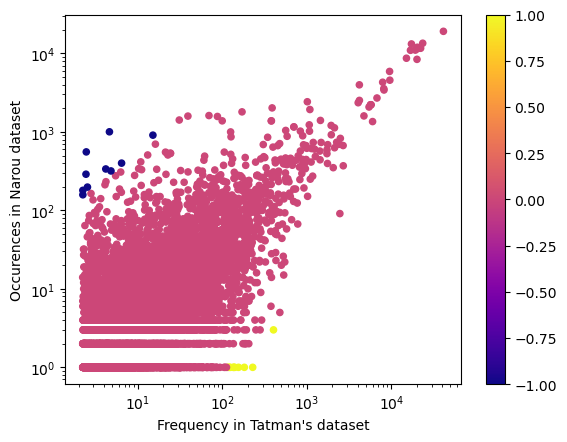

In [177]:
to_chart = in_both_datasets.copy()
to_chart['count_over_frequency'] = to_chart['count']/to_chart['frequency']
#to_chart.eval("count_over_frequency = count/frequency", inplace=True)
to_chart = to_chart.sort_values(by=['count_over_frequency'])

color_data = np.zeros_like(to_chart['count'])
color_data[:10] = 1
color_data[-10:] = -1
to_chart.plot.scatter(x='frequency', y='count', loglog=True,
                      colormap='plasma', c=color_data,
                      xlabel="Frequency in Tatman's dataset",
                      ylabel="Occurences in Narou dataset")

A scatter chart with a log-log scale will be of use in seeing how lemma frequency is correlated in each dataset -- closely at the top end, with universal grammatical features, but with wide divergence in the less common terms. Points are colored so as to highlight some that are especially characteristic of one dataset or the other, as measured by ratio of their frequencies, rather than difference in ranking. These points are worth examining more closely.

In [171]:
to_chart.head(10)

,rtatman_rank,frequency,lemma,syosetu_rank,count,rank_difference,count_over_frequency
10848,310.0,229.48,写真,16211.0,1.0,15901.0,0.004358
7873,396.0,182.73,メール,15706.0,1.0,15310.0,0.005473
12543,465.0,155.93,国際,16566.0,1.0,16101.0,0.006413
16556,507.0,141.00,昨日,18492.0,1.0,17985.0,0.007092
10217,533.0,136.52,価格,12181.0,1.0,11648.0,0.007325
15624,534.0,136.15,投資,11851.0,1.0,11317.0,0.007345
13326,192.0,404.21,委員,6351.0,3.0,6159.0,0.007422
10194,592.0,124.62,例,11717.0,1.0,11125.0,0.008024
16094,614.0,121.06,政策,13154.0,1.0,12540.0,0.008260
19394,631.0,116.41,監督,14662.0,1.0,14031.0,0.008590


In [167]:
to_chart[::-1].head(10)

,rtatman_rank,frequency,lemma,syosetu_rank,count,rank_difference,count_over_frequency
22553,14103.0,2.47,転生,93.0,556.0,-14010.0,225.101215
13353,9316.0,4.64,婚約,59.0,1003.0,-9257.0,216.163793
15110,14165.0,2.45,悪役,178.0,289.0,-13987.0,117.959184
19707,9971.0,4.20,破棄,158.0,337.0,-9813.0,80.238095
4459,14962.0,2.25,ギルド,276.0,180.0,-14686.0,80.000000
10002,13807.0,2.55,伯爵,252.0,198.0,-13555.0,77.647059
24305,14970.0,2.25,魔力,310.0,158.0,-14660.0,70.222222
22724,9074.0,4.84,追放,165.0,318.0,-8909.0,65.702479
13519,7462.0,6.46,完結,135.0,400.0,-7327.0,61.919505
19165,4047.0,15.16,異,63.0,909.0,-3984.0,59.960422


In addition to the terms identified earlier, "[iin](https://jisho.org/word/%E5%A7%94%E5%93%A1)", or committee member, seems to be disproportionately *uncommon* in the webnovel data. More terms identified as disproportionately *common* in the webnovel data include:

1. "[Konyaku](https://jisho.org/search/%E5%A9%9A%E7%B4%84)", engagement or betrothal. A common inciting incident in webnovels is a the fianc&eacute; of a female protagonist, often fitting in the "akuyaku reijou" mold, abruptly breaking their engagement.
2. "[Haki](https://jisho.org/word/%E7%A0%B4%E6%A3%84)", meaning cancellation or annulment. This is often used in combination with "konyaku".
3. "[Hakushaku](https://jisho.org/word/%E4%BC%AF%E7%88%B5)", a count or earl.
4. "[Tsuihou](https://jisho.org/word/%E8%BF%BD%E6%94%BE)", exile, a fate webnovel protagonists often receive or are threatened by as their story begins.
5. "[Kanketsu](https://jisho.org/word/%E5%AE%8C%E7%B5%90)", conclusion or completion.
6. "[I](https://jisho.org/word/%E7%95%B0)", pronounced as in "link". An adjective or prefix meaning strange or different. Most common here as the first character in "[isekai](https://jisho.org/word/%E7%95%B0%E4%B8%96%E7%95%8C)", meaning a different world or parallel universe.

In [104]:
in_both_datasets.loc[in_both_datasets['frequency'].between(2000,3000) &
                     in_both_datasets['count'].between(80,100)]

,rtatman_rank,frequency,lemma,syosetu_rank,count,rank_difference
530,39.0,2463.71,う,516.0,91.0,477.0


In [212]:
in_both_datasets.query("20 < frequency < 60 and 1000 < count < 2000")

,rtatman_rank,frequency,lemma,syosetu_rank,count,rank_difference
16721,2251.0,31.07,書籍,41.0,1417.0,-2210.0
14167,1862.0,39.31,巻,38.0,1590.0,-1824.0


*Answer to research question:* We can conclude that webnovel summaries are disproportionately likely to use language referring to fantasy concepts, and to a lesser extent referring to aspects of the production and adaptation process. They are disproportionately *unlikely* to use language relating to modern technology, politics, bureaucracy, or economics. "Kinou" fits none of these, but it may be more common in Tatman's dataset due to drawing from news articles.

In [205]:
#Visual 2 - FILL IN
def lemma_classifier(s: pd.Series):
    is_hiragana = s.str.fullmatch(r"[\u3040-\u309F]+")
    is_katakana = s.str.fullmatch(r"[\u30A0-\u30FF]+")
    is_kanji = s.str.fullmatch(r"[\u4E00-\u9FFF]+")
    s2 = (is_hiragana.map({True:1,False:0}) +
          is_katakana.map({True:2,False:0}) +
          is_kanji.map({True:3,False:0}))
    #def m(s: pd.Series, i: int): return s.map({True:i,False:0})
    #s2 = m(is_hiragana, 1) + m(is_katakana, 2) + m(is_kanji, 3)
    s2 = s2.astype('category')
    cats = {0:'Mixed', 1:'All hiragana', 2:'All katakana', 3:'All kanji'}
    return s2.cat.rename_categories(cats)

lemma_groups = pd.DataFrame({
    'category': lemma_classifier(combined_lemma_rankings['lemma']),
    'rtatman_frequency': combined_lemma_rankings['frequency'],
    'syosetu_count': combined_lemma_rankings['count'],
})
# -----------------------------------------------------------------------------
lemma_groups.sort_values(by='rtatman_frequency', ascending=False, inplace=True)
lemma_groups = lemma_groups.groupby('category').sum()

C:\Users\piwv\AppData\Local\Temp\ipykernel_22760\429617212.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lemma_groups = lemma_groups.groupby('category').sum()


<Axes: >

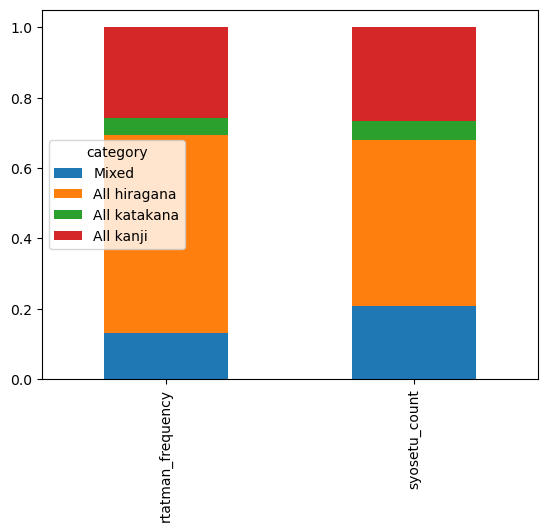

In [206]:
def to_frac(s: pd.Series): return s.div(s.sum())

for c in lemma_groups.columns:
    lemma_groups[c] = to_frac(lemma_groups[c])
lemma_groups.T.plot.bar(stacked=True)

*Answer to research question:* When lemmas are categorized by what kind of characters they include and weighted by frequency, little difference is apparent between the webnovel dataset and Tatman's. The only exception is a slightly smaller proportion of hiragana-only lemmas, and a larger proportion of mixed-character-type lemmas. Comparisons are also difficult because Tatman's dataset is limited to the top 15,000 from a large corpus, while ours is much smaller (less than 500,000 tokens total compared to 253,000,000), and we're including every lemma we found; we don't know how the absent "tail" of Tatman's source corpus would affect things.

### **5.2:** Reflection
In 2-4 sentences, if you had more time to complete the project, what actions would you take? For example, which data quality and structural issues would you look into further, and what research questions would you further explore?

*Answer:* I would like to further refine the datasets to remove unwanted entries, or see if the lemmatization process can be improved. Conceivably, comparisons could also be made with text from the stories themselves, from stories published at different times, or from other Japanese webnovel sites such as Kakuyomu.

Expanding the dataset from Shousetsuka ni Narou would also be an option. The maximum "start position" permitted by the API is 2,000, but more could be retrieved by partitioning the site's stories into two groups, such as "romance" and "fantasy" stories versus all others, and combining data for the top 2,000 stories in each group.